### Introduction

This notebook contains my code for Assignment 3.

#### Load Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir("D:\\Datasets\\MSDS_458_Assignment_3")

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from packaging import version
from collections import Counter

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0
Keras version:  2.5.0


#### Functions

Here are some helper functions:

In [2]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

#### Load Dataset

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.

ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
INFO[dataset_info.py]: Load dataset info from C:\Users\khark\tensorflow_datasets\ag_news_subset\1.0.0
INFO[build.py]: download_and_prepare for dataset ag_news_subset/1.0.0...
INFO[dataset_builder.py]: Reusing dataset ag_news_subset (C:\Users\khark\tensorflow_datasets\ag_news_subset\1.0.0)
INFO[build.py]: Dataset generation complete...

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
    information retrieval (ranking, search, etc), xml, 

2021-08-07 13:54:27.372985: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
W0807 13:54:30.393684 27496 download_and_prepare.py:42] ***`tfds build` should be used instead of `download_and_prepare`.***


### Exploratory Analysis on the AG News Subset

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
    information retrieval (ranking, search, etc), xml, data compression, data streaming,
    and any other non-commercial activity.
    For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
    It is used as a text classification benchmark in the following paper:
    Xiang Zhang, Junbo Zhao, Yann LeCun. Char

In [5]:
tfds.as_dataframe(dataset_all.take(10),info)

print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

categories = dict(enumerate(info.features["label"].names))
categories

train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Pre-processing Data to Create Input Pipeline

In [6]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
INFO[dataset_info.py]: Load dataset info from C:\Users\khark\tensorflow_datasets\ag_news_subset\1.0.0
INFO[build.py]: download_and_prepare for dataset ag_news_subset/1.0.0...
INFO[dataset_builder.py]: Reusing dataset ag_news_subset (C:\Users\khark\tensorflow_datasets\ag_news_subset\1.0.0)
INFO[build.py]: Dataset generation complete...

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
    information retrieval (ranking, search, etc), xml, 

2021-08-07 13:54:47.716346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
W0807 13:54:50.662095 29332 download_and_prepare.py:42] ***`tfds build` should be used instead of `download_and_prepare`.***


### Review Distribution of Categorical Labels for the Training Data

In [7]:
len(train_dataset), len(validation_dataset), len(test_dataset)
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('class: ', categories[label.numpy()])

(114000, 6000, 7600)

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


### Preprocess Data for Training to Create Batches of (text, label) pairs

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE= 1000

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

for example, label in train_dataset.take(2):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

for example, label in train_dataset.take(2):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', [categories[n] for n in label.numpy()[:3]])
    print()

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
len(vocab)
vocab[:20]

encoded_example = encoder(example)[:3].numpy()
encoded_example

for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'It #39;s back -- the season of peace, good fellowship, and digital marvels. The Entertainment Software Association reckons that nearly one third of all Americans will give a computer game as a Christmas gift in 2004.'
 b'SOFTWARE HACKERS are using snaps which they claim show David Beckham in a compromising position to infect people #39;s computers. Beckham, who apparently plays football, and is married to a member of a popular '
 b'Brazilian tennis player Ricardo Mello has upset top seed Vince Spadea to win the hard court event in Delray Beach, Florida. Mello made his first appearance in an ATP final a memorable one, defeating the American 7-6 (7/2), 6-3.']

labels:  [3 3 1]
texts:  [b"The funeral of one of the last century's greatest known ballerinas, Dame Alicia Markova, is held in Bath."
 b'Some area employers expect to maintain a steady hiring pace during the fourth quarter of 2004, according to a survey released yesterday by Manpower Inc.'
 b'This week #39;s Golkar Part

1000

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

array([[  1, 188,  14,   2,   1, 401,  11,   1,   1, 218,   4, 349,  38,
          1,   1,  23, 144, 305, 188, 588,   9,   1,  69,   1,   1, 118,
          4,   1, 684,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  25,   1, 603,   5,   1,   1,  68,   3,   1, 528, 247,  24,
          1,   6, 231,   2,  25, 232,  17,  73,  79, 123, 151, 673,  61,
          1,   1,   6,   2, 589, 341,  37,   1,   4,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [ 28, 312, 148,  97,   1,   1, 269, 215,   1,   1,  17,   6,   1,
         73,  53,  74,  31,   1,   4, 757, 912,   1,  61,   1, 130,   3,
          1,   1, 269, 250,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0

Original:  b'Danske Bank A/S, the Nordic region #39;s second-largest lender, agreed to buy two Irish units from National Australia Bank Ltd. for 967 million pounds (\\$1.86 billion) to expand outside Scandinavia.'
Round-trip:  [UNK] bank as the [UNK] region 39s [UNK] [UNK] agreed to buy two [UNK] [UNK] from national australia bank ltd for [UNK] million [UNK] [UNK] billion to [UNK] outside [UNK]                              

Original:  b'A U.S. soldier died of wounds sustained when a roadside bomb hit his patrol in Baghdad, the U.S. military said Sunday. Three other American soldiers were slightly wounded in the same attack but returned to duty.'
Round-trip:  a us [UNK] died of [UNK] [UNK] when a [UNK] bomb hit his [UNK] in baghdad the us military said sunday three other american soldiers were [UNK] [UNK] in the same attack but [UNK] to [UNK]                        

Original:  b'Reuters - Israeli Prime Minister Ariel Sharon\\and Palestinian leader Mahmoud Abbas said in interviews\\pub

### RNN Models

In [12]:
# First RNN Model - Using only 64 SimpleRNN() layers

def rnn1(encoder, num_classes=4):
    model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                       output_dim=64,
                                                       # Use masking to handle the variable sequence lengths
                                                       mask_zero=False),
                             tf.keras.layers.SimpleRNN(64),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')   # num_classes = 4
                            ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  # if we set from_logits=True we don not have specify a softmax activation function in the last layer
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    print([layer.supports_masking for layer in model.layers])
    
    history = model.fit(train_dataset,
                        epochs = 200,
                        validation_data=validation_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
    model.summary()

    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
    preds = model.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    return model

[False, False, True, True, True]
Epoch 1/200
1782/1782 [==============================] - 138s 77ms/step - loss: 1.0523 - accuracy: 0.4843 - val_loss: 0.6661 - val_accuracy: 0.7695
Epoch 2/200
1782/1782 [==============================] - 136s 77ms/step - loss: 0.5682 - accuracy: 0.8037 - val_loss: 0.5429 - val_accuracy: 0.8140
Epoch 3/200
1782/1782 [==============================] - 135s 76ms/step - loss: 0.5067 - accuracy: 0.8249 - val_loss: 0.4848 - val_accuracy: 0.8368
Epoch 4/200
1782/1782 [==============================] - 136s 76ms/step - loss: 0.4836 - accuracy: 0.8316 - val_loss: 0.4757 - val_accuracy: 0.8387
Epoch 5/200
1782/1782 [==============================] - 136s 76ms/step - loss: 0.4743 - accuracy: 0.8329 - val_loss: 0.4759 - val_accuracy: 0.8357
Epoch 6/200
1782/1782 [==============================] - 136s 76ms/step - loss: 0.4641 - accuracy: 0.8356 - val_loss: 0.4646 - val_accuracy: 0.8378
Model: "sequential_1"
_________________________________________________________

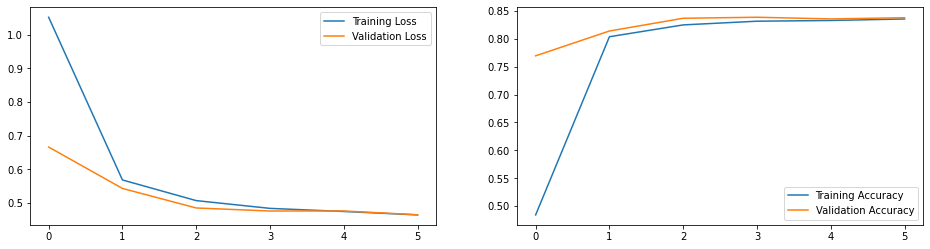

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.029082,0.992894,0.005170,0.065958,0.984702,0.015231,0.027745,0.304642,0.785099,0.047974,0.993032,0.018597,0.028742,0.817880,0.991066
Sports,0.962760,0.000948,0.000999,0.906633,0.004206,0.003250,0.958534,0.588587,0.057109,0.002959,0.001296,0.023204,0.000341,0.058186,0.002345
Business,0.002206,0.002933,0.034103,0.007511,0.004893,0.166719,0.004067,0.032638,0.079809,0.789413,0.002439,0.050756,0.942178,0.054353,0.002762
Sci/Tech,0.005952,0.003225,0.959728,0.019897,0.006200,0.814800,0.009655,0.074133,0.077982,0.159654,0.003232,0.907443,0.028740,0.069581,0.003827


In [13]:
rnn_model_1 = rnn1(encoder, num_classes=4)

In [14]:
# Using only 32 SimpleRNN() layers

def rnn2(encoder, num_classes=4):
    model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                       output_dim=64,
                                                       # Use masking to handle the variable sequence lengths
                                                       mask_zero=False),
                             tf.keras.layers.SimpleRNN(32),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')   # num_classes = 4
                            ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  # if we set from_logits=True we don not have specify a softmax activation function in the last layer
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    print([layer.supports_masking for layer in model.layers])
    
    history = model.fit(train_dataset,
                        epochs = 200,
                        validation_data=validation_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
    model.summary()

    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
    preds = model.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    return model

[False, False, True, True, True]
Epoch 1/200
1782/1782 [==============================] - 135s 75ms/step - loss: 1.0584 - accuracy: 0.4448 - val_loss: 0.9474 - val_accuracy: 0.4853
Epoch 2/200
1782/1782 [==============================] - 135s 76ms/step - loss: 0.8606 - accuracy: 0.5645 - val_loss: 0.7737 - val_accuracy: 0.6443
Epoch 3/200
1782/1782 [==============================] - 133s 75ms/step - loss: 0.7364 - accuracy: 0.6572 - val_loss: 0.7233 - val_accuracy: 0.6563
Epoch 4/200
1782/1782 [==============================] - 132s 74ms/step - loss: 0.6953 - accuracy: 0.6740 - val_loss: 0.6880 - val_accuracy: 0.6745
Epoch 5/200
1782/1782 [==============================] - 133s 75ms/step - loss: 0.6732 - accuracy: 0.6855 - val_loss: 0.6707 - val_accuracy: 0.6822
Epoch 6/200
1782/1782 [==============================] - 135s 76ms/step - loss: 0.6573 - accuracy: 0.7072 - val_loss: 0.6629 - val_accuracy: 0.7037
Epoch 7/200
1782/1782 [==============================] - 135s 76ms/step - loss:

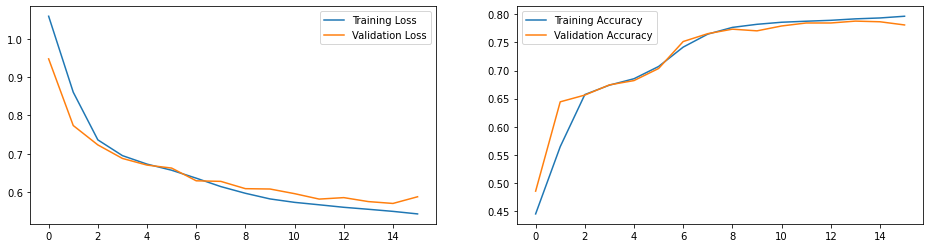

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.009351,0.955245,0.025967,0.011439,0.915704,0.064165,0.023294,0.099133,0.882796,0.020969,0.918253,0.599951,0.010935,0.875620,0.938016
Sports,0.989171,0.005162,0.000449,0.986203,0.051878,0.006735,0.974809,0.861882,0.050904,0.002977,0.045057,0.007634,0.002628,0.042179,0.013727
Business,0.001341,0.002116,0.248590,0.002115,0.003043,0.641946,0.001503,0.022640,0.016616,0.781248,0.004051,0.041121,0.854053,0.011284,0.006934
Sci/Tech,0.000136,0.037477,0.724994,0.000243,0.029375,0.287154,0.000394,0.016345,0.049685,0.194806,0.032639,0.351294,0.132383,0.070917,0.041323


In [15]:
rnn_model_2 = rnn2(encoder, num_classes=4)

In [18]:
# Using 1 x 16 SimpleRNN() layers

def rnn3(encoder, num_classes=4):
    model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                       output_dim=64,
                                                       # Use masking to handle the variable sequence lengths
                                                       mask_zero=False),
                             tf.keras.layers.SimpleRNN(16),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')   # num_classes = 4
                            ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  # if we set from_logits=True we don not have specify a softmax activation function in the last layer
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    print([layer.supports_masking for layer in model.layers])
    
    history = model.fit(train_dataset,
                        epochs = 200,
                        validation_data=validation_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
    model.summary()

    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
    preds = model.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    return model

[False, False, True, True, True]
Epoch 1/200
1782/1782 [==============================] - 140s 78ms/step - loss: 1.1019 - accuracy: 0.4325 - val_loss: 0.9552 - val_accuracy: 0.4730
Epoch 2/200
1782/1782 [==============================] - 137s 77ms/step - loss: 0.9171 - accuracy: 0.4890 - val_loss: 0.9002 - val_accuracy: 0.5135
Epoch 3/200
1782/1782 [==============================] - 138s 77ms/step - loss: 0.8346 - accuracy: 0.5827 - val_loss: 0.7767 - val_accuracy: 0.6373
Epoch 4/200
1782/1782 [==============================] - 138s 77ms/step - loss: 0.7329 - accuracy: 0.6511 - val_loss: 0.7274 - val_accuracy: 0.6472
Epoch 5/200
1782/1782 [==============================] - 138s 77ms/step - loss: 0.6998 - accuracy: 0.6607 - val_loss: 0.7189 - val_accuracy: 0.6512
Epoch 6/200
1782/1782 [==============================] - 141s 79ms/step - loss: 0.6781 - accuracy: 0.6663 - val_loss: 0.6838 - val_accuracy: 0.6640
Epoch 7/200
1782/1782 [==============================] - 138s 78ms/step - loss:

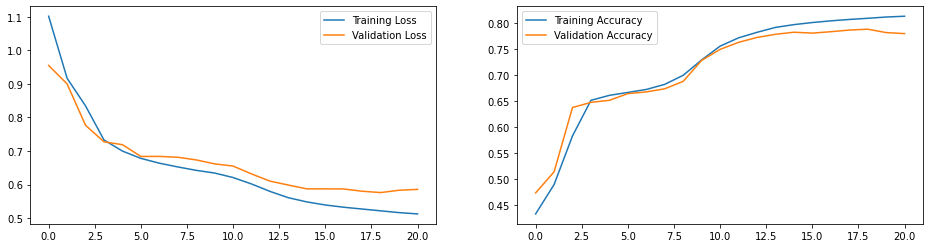

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.021027,0.948418,0.000685,0.030524,0.950146,0.012363,0.019563,0.082415,0.821756,0.061359,0.970683,0.020997,0.076648,0.877121,0.926978
Sports,0.973210,0.010848,0.000138,0.955782,0.015941,0.001342,0.976861,0.881170,0.043316,0.001897,0.006511,0.006969,0.000173,0.008669,0.001182
Business,0.000340,0.035793,0.190892,0.000766,0.029324,0.385418,0.000228,0.004321,0.098239,0.697404,0.021249,0.164335,0.891968,0.100044,0.069416
Sci/Tech,0.005423,0.004941,0.808285,0.012927,0.004588,0.600877,0.003348,0.032094,0.036689,0.239341,0.001557,0.807699,0.031210,0.014166,0.002424


In [19]:
rnn_model_3 = rnn3(encoder, num_classes=4)

In [20]:
# Using 1 x 32 Bidirectional SimpleRNN() layers

def rnn4(encoder, num_classes=4):
    model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                       output_dim=64,
                                                       # Use masking to handle the variable sequence lengths
                                                       mask_zero=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')   # num_classes = 4
                            ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  # if we set from_logits=True we don not have specify a softmax activation function in the last layer
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    print([layer.supports_masking for layer in model.layers])
    
    history = model.fit(train_dataset,
                        epochs = 200,
                        validation_data=validation_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
    model.summary()

    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
    preds = model.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    return model

[False, False, True, True, True]
Epoch 1/200
1782/1782 [==============================] - 259s 144ms/step - loss: 0.9076 - accuracy: 0.6126 - val_loss: 0.5632 - val_accuracy: 0.7993
Epoch 2/200
1782/1782 [==============================] - 256s 143ms/step - loss: 0.5081 - accuracy: 0.8170 - val_loss: 0.4781 - val_accuracy: 0.8287
Epoch 3/200
1782/1782 [==============================] - 250s 140ms/step - loss: 0.4690 - accuracy: 0.8314 - val_loss: 0.4596 - val_accuracy: 0.8333
Epoch 4/200
1782/1782 [==============================] - 254s 142ms/step - loss: 0.4535 - accuracy: 0.8354 - val_loss: 0.4653 - val_accuracy: 0.8328
Epoch 5/200
1782/1782 [==============================] - 254s 143ms/step - loss: 0.4435 - accuracy: 0.8383 - val_loss: 0.4433 - val_accuracy: 0.8383
Epoch 6/200
1782/1782 [==============================] - 255s 143ms/step - loss: 0.4331 - accuracy: 0.8421 - val_loss: 0.4383 - val_accuracy: 0.8387
Epoch 7/200
1782/1782 [==============================] - 252s 141ms/step 

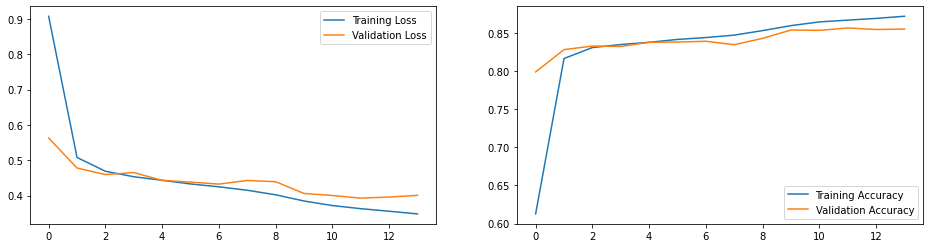

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.000065,0.998755,0.001608,0.005005,0.997837,0.006460,0.017476,0.112628,0.955780,0.003494,0.997141,0.001199,0.011054,0.964373,0.999064
Sports,0.999779,0.000141,0.000193,0.993730,0.000197,0.015365,0.979763,0.861791,0.004518,0.000325,0.000410,0.003247,0.000387,0.006411,0.000014
Business,0.000018,0.000493,0.014175,0.000458,0.000372,0.159940,0.001115,0.001616,0.012210,0.923365,0.001039,0.005076,0.939312,0.012415,0.000572
Sci/Tech,0.000138,0.000610,0.984024,0.000806,0.001594,0.818236,0.001646,0.023964,0.027492,0.072816,0.001410,0.990478,0.049247,0.016801,0.000350


In [21]:
rnn_model_4 = rnn4(encoder, num_classes=4)

In [22]:
# Using 1 x 64 Bidirectional SimpleRNN() layers

def rnn5(encoder, num_classes=4):
    model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                       output_dim=64,
                                                       # Use masking to handle the variable sequence lengths
                                                       mask_zero=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')   # num_classes = 4
                            ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  # if we set from_logits=True we don not have specify a softmax activation function in the last layer
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    print([layer.supports_masking for layer in model.layers])
    
    history = model.fit(train_dataset,
                        epochs = 20,
                        validation_data=validation_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
    model.summary()

    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
    preds = model.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    return model

[False, False, True, True, True]
Epoch 1/20
1782/1782 [==============================] - 250s 140ms/step - loss: 0.7970 - accuracy: 0.6548 - val_loss: 0.5134 - val_accuracy: 0.8098
Epoch 2/20
1782/1782 [==============================] - 249s 139ms/step - loss: 0.4891 - accuracy: 0.8231 - val_loss: 0.4630 - val_accuracy: 0.8357
Epoch 3/20
1782/1782 [==============================] - 247s 139ms/step - loss: 0.4434 - accuracy: 0.8405 - val_loss: 0.4283 - val_accuracy: 0.8477
Epoch 4/20
1782/1782 [==============================] - 247s 138ms/step - loss: 0.4143 - accuracy: 0.8515 - val_loss: 0.4175 - val_accuracy: 0.8562
Epoch 5/20
1782/1782 [==============================] - 248s 139ms/step - loss: 0.4000 - accuracy: 0.8564 - val_loss: 0.4070 - val_accuracy: 0.8572
Epoch 6/20
1782/1782 [==============================] - 253s 142ms/step - loss: 0.3897 - accuracy: 0.8595 - val_loss: 0.4157 - val_accuracy: 0.8487
Epoch 7/20
1782/1782 [==============================] - 255s 143ms/step - loss:

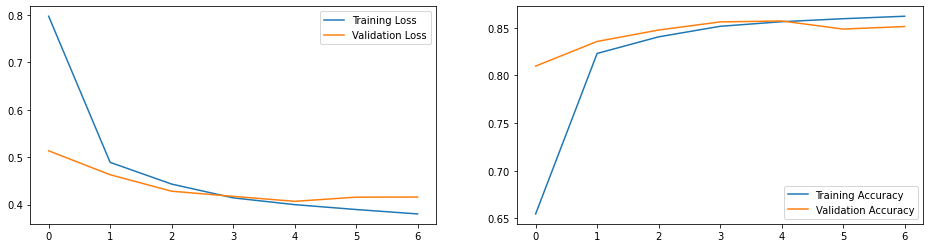

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.002104,0.996703,0.004401,0.023237,0.997484,0.008928,0.009755,0.648477,0.845308,0.017578,0.998033,0.008155,0.010804,0.791218,0.998351
Sports,0.996934,0.001087,0.000737,0.970666,0.000364,0.003050,0.986552,0.290259,0.037017,0.001474,0.000469,0.007138,0.000514,0.045455,0.000042
Business,0.000190,0.001230,0.054331,0.002626,0.000894,0.245838,0.000855,0.001939,0.022946,0.880536,0.001007,0.012100,0.972665,0.080776,0.001119
Sci/Tech,0.000772,0.000979,0.940531,0.003471,0.001257,0.742184,0.002838,0.059325,0.094729,0.100412,0.000492,0.972607,0.016017,0.082551,0.000489


In [23]:
rnn_model_5 = rnn5(encoder, num_classes=4)

### LSTM Models

In [35]:
def lstm1(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=200,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/200
1782/1782 [==============================] - 74s 33ms/step - loss: 0.5172 - accuracy: 0.8141 - val_loss: 0.4021 - val_accuracy: 0.8615
Epoch 2/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4272 - accuracy: 0.8509 - val_loss: 0.4266 - val_accuracy: 0.8458
Epoch 3/200
119/119 [==============================] - 1s 10ms/step - loss: 0.4120 - accuracy: 0.8497
Test Loss: 0.4119947850704193
Test Accuracy: 0.8497368693351746


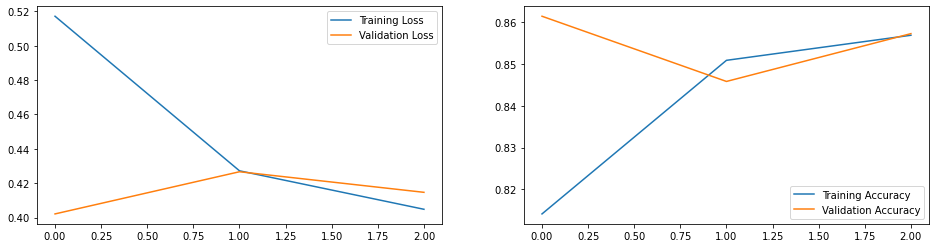

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.001325,0.999690,0.001453,0.011706,0.997993,0.008560,0.012298,0.121928,0.968691,0.002661,0.999320,0.007511,0.002947,0.968168,0.998892
Sports,0.998642,0.000035,0.000155,0.987975,0.000166,0.005632,0.986624,0.873320,0.005387,0.000159,0.000053,0.001448,0.000047,0.008632,0.000068
Business,0.000010,0.000136,0.046238,0.000148,0.001217,0.165332,0.000457,0.001049,0.007882,0.874756,0.000325,0.011448,0.985695,0.006952,0.000539
Sci/Tech,0.000024,0.000139,0.952154,0.000171,0.000624,0.820476,0.000621,0.003702,0.018039,0.122424,0.000301,0.979593,0.011311,0.016249,0.000502


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

In [36]:
lstm_model_1 = lstm1(encoder, num_classes=4)

In [37]:
def lstm2(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                  tf.keras.layers.Dense(32, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=200,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/200
1782/1782 [==============================] - 72s 31ms/step - loss: 0.5526 - accuracy: 0.8054 - val_loss: 0.4206 - val_accuracy: 0.8562
Epoch 2/200
1782/1782 [==============================] - 51s 29ms/step - loss: 0.4474 - accuracy: 0.8491 - val_loss: 0.3768 - val_accuracy: 0.8682
Epoch 3/200
1782/1782 [==============================] - 51s 28ms/step - loss: 0.4260 - accuracy: 0.8540 - val_loss: 0.3854 - val_accuracy: 0.8609
Epoch 4/200
119/119 [==============================] - 1s 10ms/step - loss: 0.3992 - accuracy: 0.8495
Test Loss: 0.3991585075855255
Test Accuracy: 0.8494736552238464


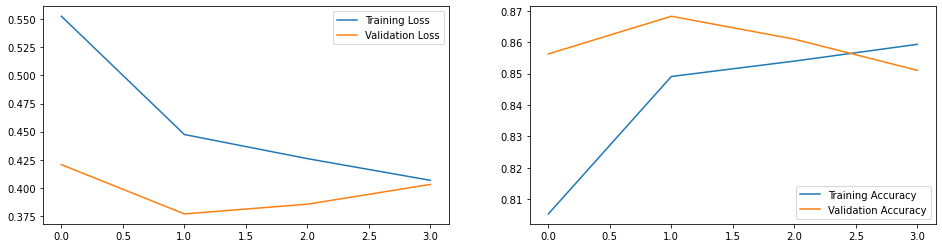

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,4.895752e-04,0.999637,0.000250,0.011360,0.997368,0.002733,0.007811,0.113843,0.797726,0.002416,0.999748,0.002933,9.898458e-04,0.783288,0.997267
Sports,9.995067e-01,0.000004,0.000010,0.988427,0.000012,0.000538,0.991253,0.877872,0.008139,0.000065,0.000002,0.001159,7.667118e-07,0.017840,0.000003
Business,5.280926e-07,0.000226,0.101828,0.000043,0.002096,0.150552,0.000206,0.000972,0.034183,0.816811,0.000160,0.015460,9.980563e-01,0.031465,0.002239
Sci/Tech,3.219383e-06,0.000133,0.897913,0.000170,0.000523,0.846177,0.000731,0.007313,0.159952,0.180708,0.000091,0.980449,9.531796e-04,0.167407,0.000491


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 64)          24832     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 4)                

In [39]:
lstm_model_2 = lstm2(encoder, num_classes=4)

In [24]:
def lstm3(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=200,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/200
1782/1782 [==============================] - 73s 32ms/step - loss: 0.5143 - accuracy: 0.8147 - val_loss: 0.4226 - val_accuracy: 0.8604
Epoch 2/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4289 - accuracy: 0.8505 - val_loss: 0.4049 - val_accuracy: 0.8589
Epoch 3/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4063 - accuracy: 0.8567 - val_loss: 0.3838 - val_accuracy: 0.8609
Epoch 4/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.3848 - accuracy: 0.8629 - val_loss: 0.3487 - val_accuracy: 0.8641
Epoch 5/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.3674 - accuracy: 0.8684 - val_loss: 0.3812 - val_accuracy: 0.8620
Epoch 6/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.3516 - accuracy: 0.8735 - val_loss: 0.3632 - val_accuracy: 0.8682
Epoch 7/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.3353 - accuracy: 0.8786 - val_loss: 0

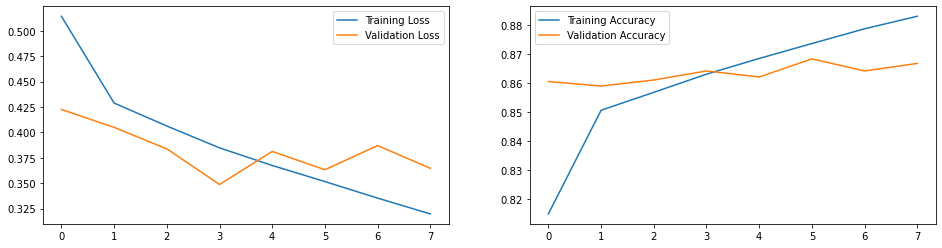

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,1.114455e-04,0.999658,0.000046,0.001570,0.999495,0.002337,0.001025,0.010916,0.816832,0.001128,0.998907,0.000104,0.001295,0.765149,0.997122
Sports,9.998852e-01,0.000001,0.000021,0.998362,0.000007,0.000634,0.998499,0.984461,0.012062,0.000024,0.000054,0.000006,0.000001,0.018195,0.000011
Business,4.542329e-07,0.000234,0.034564,0.000024,0.000370,0.229519,0.000183,0.000221,0.037223,0.740926,0.000709,0.013819,0.995585,0.074861,0.002358
Sci/Tech,2.823943e-06,0.000106,0.965369,0.000044,0.000128,0.767511,0.000293,0.004402,0.133883,0.257922,0.000329,0.986072,0.003118,0.141794,0.000509


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

In [25]:
lstm_model_3 = lstm3(encoder, num_classes=4)

In [26]:
# Increasing Dropout to 0.75
def lstm4(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.75),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=200,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/200
1782/1782 [==============================] - 72s 32ms/step - loss: 0.5804 - accuracy: 0.7967 - val_loss: 0.4354 - val_accuracy: 0.8333
Epoch 2/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4802 - accuracy: 0.8402 - val_loss: 0.4374 - val_accuracy: 0.8448
Epoch 3/200
1782/1782 [==============================] - 53s 29ms/step - loss: 0.4537 - accuracy: 0.8487 - val_loss: 0.4033 - val_accuracy: 0.8583
Epoch 4/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4323 - accuracy: 0.8541 - val_loss: 0.4014 - val_accuracy: 0.8635
Epoch 5/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4149 - accuracy: 0.8586 - val_loss: 0.3978 - val_accuracy: 0.8599
Epoch 6/200
1782/1782 [==============================] - 52s 29ms/step - loss: 0.3966 - accuracy: 0.8640 - val_loss: 0.3872 - val_accuracy: 0.8703
Epoch 7/200
1782/1782 [==============================] - 52s 29ms/step - loss: 0.3815 - accuracy: 0.8680 - val_loss: 0

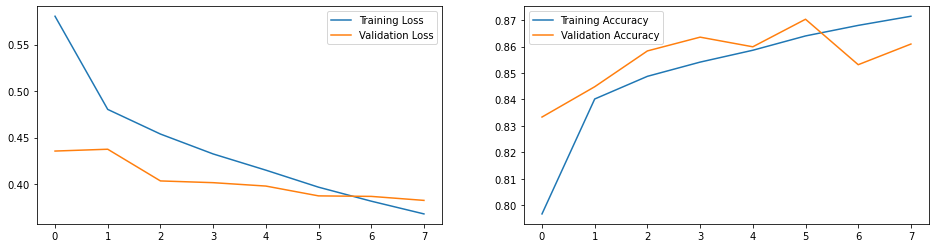

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,5.789059e-08,9.999994e-01,2.063574e-04,1.959491e-03,9.999923e-01,0.004969,0.003195,0.079844,0.895233,0.003325,9.999939e-01,0.000312,0.003723,0.949295,9.999964e-01
Sports,1.000000e+00,3.713343e-12,3.326864e-07,9.980336e-01,2.787778e-09,0.000375,0.996584,0.913523,0.002859,0.000014,1.777824e-10,0.000001,0.000002,0.005105,2.165102e-10
Business,1.093795e-14,1.307269e-07,8.333157e-03,6.756259e-07,2.884418e-06,0.186974,0.000050,0.001290,0.031175,0.941219,9.099604e-07,0.010372,0.985791,0.012794,1.361882e-06
Sci/Tech,3.733805e-13,4.338783e-07,9.914601e-01,6.176472e-06,4.846072e-06,0.807682,0.000171,0.005343,0.070733,0.055442,5.128654e-06,0.989314,0.010483,0.032807,2.264285e-06


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                

In [27]:
lstm_model_4 = lstm4(encoder, num_classes=4)

In [28]:
# Increasing the second layer to 128, keeping dropout at 0.75

def lstm5(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.75),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=200,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/200
1782/1782 [==============================] - 78s 35ms/step - loss: 0.5787 - accuracy: 0.7997 - val_loss: 0.4199 - val_accuracy: 0.8578
Epoch 2/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.4808 - accuracy: 0.8416 - val_loss: 0.4153 - val_accuracy: 0.8510
Epoch 3/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.4550 - accuracy: 0.8480 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 4/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.4336 - accuracy: 0.8530 - val_loss: 0.3863 - val_accuracy: 0.8630
Epoch 5/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.4153 - accuracy: 0.8587 - val_loss: 0.3707 - val_accuracy: 0.8651
Epoch 6/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.3996 - accuracy: 0.8638 - val_loss: 0.4069 - val_accuracy: 0.8552
Epoch 7/200
1782/1782 [==============================] - 57s 32ms/step - loss: 0.3805 - accuracy: 0.8680 - val_loss: 0

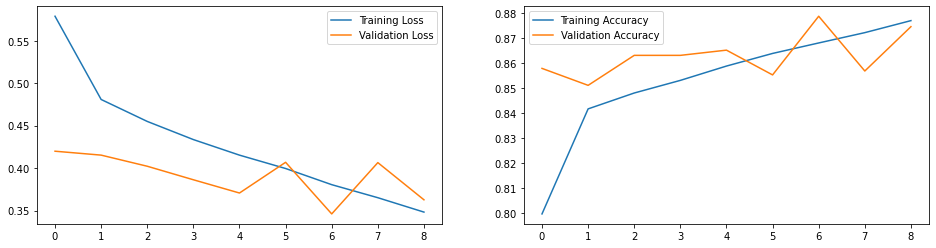

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,8.805097e-08,9.999993e-01,1.502109e-04,0.004308,9.999249e-01,0.009133,0.004719,0.025263,0.858141,0.004744,0.999792,1.257335e-04,6.867577e-03,0.948100,9.999976e-01
Sports,9.999999e-01,1.792158e-12,2.735865e-07,0.995640,2.891634e-08,0.000841,0.994751,0.971043,0.008975,0.000001,0.000007,1.357344e-08,5.137873e-07,0.017001,4.916035e-11
Business,5.797612e-15,2.821543e-08,3.125985e-03,0.000006,1.523609e-05,0.389963,0.000104,0.000513,0.022156,0.976298,0.000021,4.506484e-03,9.879032e-01,0.007930,4.957002e-07
Sci/Tech,2.425840e-13,6.328249e-07,9.967235e-01,0.000047,5.990529e-05,0.600063,0.000426,0.003181,0.110728,0.018957,0.000180,9.953678e-01,5.228754e-03,0.026969,1.875124e-06


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         197632    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 4)                

In [29]:
lstm_model_5 = lstm5(encoder, num_classes=4)

In [ ]:
%%javascript
IPython.notebook.save_notebook()

### CNN Models

In [35]:
# Baseline CNN Model

def cnn1(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Conv1D(64, 3, activation='relu'),
                                  tf.keras.layers.GlobalMaxPooling1D(),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=20,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/20
1782/1782 [==============================] - 26s 13ms/step - loss: 0.5345 - accuracy: 0.8095 - val_loss: 0.4122 - val_accuracy: 0.8531
Epoch 2/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.4125 - accuracy: 0.8580 - val_loss: 0.4028 - val_accuracy: 0.8573
Epoch 3/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.3815 - accuracy: 0.8680 - val_loss: 0.3990 - val_accuracy: 0.8573
Epoch 4/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.3549 - accuracy: 0.8759 - val_loss: 0.3764 - val_accuracy: 0.8641
Epoch 5/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.3324 - accuracy: 0.8832 - val_loss: 0.4169 - val_accuracy: 0.8516
Epoch 6/20
119/119 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.8603
Test Loss: 0.4024028778076172
Test Accuracy: 0.8602631688117981


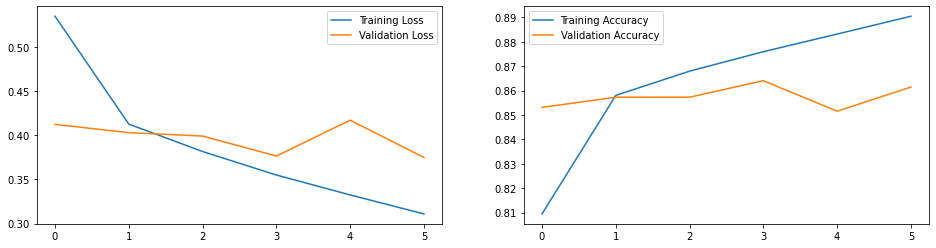

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,1.098137e-05,0.999954,0.000079,0.001370,0.999621,0.000393,0.002608,0.012031,0.993610,0.005775,0.999720,0.000825,0.022648,0.991949,9.986494e-01
Sports,9.999890e-01,0.000005,0.000005,0.998617,0.000035,0.000086,0.996900,0.987809,0.000174,0.000115,0.000026,0.003930,0.000150,0.000693,1.131132e-07
Business,7.472019e-09,0.000038,0.061005,0.000007,0.000021,0.156308,0.000111,0.000010,0.000716,0.986008,0.000223,0.010041,0.965132,0.001991,2.828925e-04
Sci/Tech,2.422514e-08,0.000002,0.938911,0.000006,0.000324,0.843213,0.000381,0.000150,0.005500,0.008103,0.000031,0.985204,0.012070,0.005366,1.067552e-03


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)               

In [36]:
cnn_model_1 = cnn1(encoder, num_classes=4)

In [37]:
# CNN Model, with 64 conv1d nodes, and 0.75 dropout

def cnn2(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Conv1D(64, 3, activation='relu'),
                                  tf.keras.layers.GlobalMaxPooling1D(),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.75),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=20,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/20
1782/1782 [==============================] - 11s 6ms/step - loss: 0.6432 - accuracy: 0.7652 - val_loss: 0.4143 - val_accuracy: 0.8589
Epoch 2/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.4871 - accuracy: 0.8380 - val_loss: 0.4170 - val_accuracy: 0.8578
Epoch 3/20
119/119 [==============================] - 0s 4ms/step - loss: 0.4065 - accuracy: 0.8542: 0s - loss: 0.4068 - accuracy: 
Test Loss: 0.4065132439136505
Test Accuracy: 0.8542105555534363


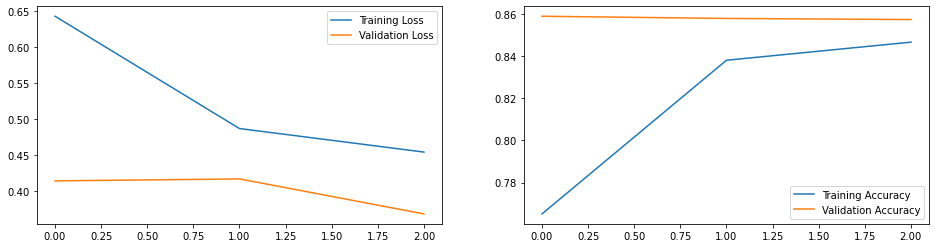

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,2.094409e-04,9.999547e-01,0.000665,0.002297,0.999369,0.003499,0.001927,0.094926,0.994143,0.020424,9.999864e-01,0.013976,0.032830,0.978017,0.996855
Sports,9.997889e-01,2.562747e-07,0.000005,0.997682,0.000023,0.000445,0.998059,0.901721,0.000134,0.000152,2.779152e-08,0.066597,0.000025,0.000880,0.000004
Business,6.597775e-08,2.802633e-05,0.022678,0.000003,0.000075,0.285929,0.000001,0.000135,0.000580,0.899941,4.597200e-06,0.033005,0.958074,0.008397,0.001471
Sci/Tech,1.612509e-06,1.705184e-05,0.976652,0.000018,0.000532,0.710128,0.000012,0.003218,0.005143,0.079483,9.011333e-06,0.886422,0.009071,0.012705,0.001670


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)               

In [38]:
cnn_model_2 = cnn2(encoder, num_classes=4)

In [39]:
# CNN Model, with 128 conv1d nodes, and 0.5 dropout

def cnn3(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Conv1D(128, 3, activation='relu'),
                                  tf.keras.layers.GlobalMaxPooling1D(),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=20,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/20
1782/1782 [==============================] - 18s 10ms/step - loss: 0.5390 - accuracy: 0.8099 - val_loss: 0.3863 - val_accuracy: 0.8693
Epoch 2/20
1782/1782 [==============================] - 10s 6ms/step - loss: 0.4134 - accuracy: 0.8573 - val_loss: 0.3437 - val_accuracy: 0.8750
Epoch 3/20
1782/1782 [==============================] - 10s 5ms/step - loss: 0.3831 - accuracy: 0.8668 - val_loss: 0.3721 - val_accuracy: 0.8651
Epoch 4/20
119/119 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8645
Test Loss: 0.378263384103775
Test Accuracy: 0.8644737005233765


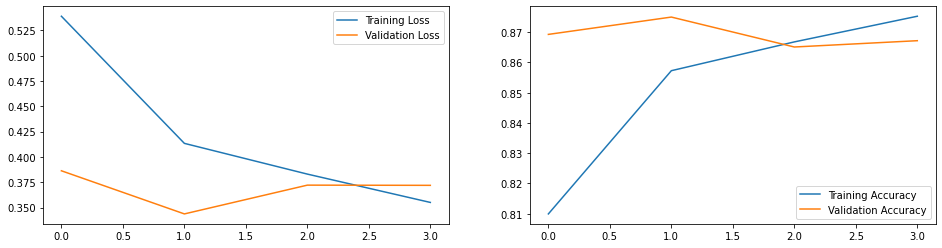

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,1.372602e-05,9.999628e-01,0.000049,0.011516,0.999324,0.000752,0.034836,0.060517,0.960208,0.003928,0.999382,0.003446,0.015425,0.984688,0.996411
Sports,9.999862e-01,4.620432e-07,0.000002,0.988072,0.000012,0.000562,0.962695,0.935936,0.000203,0.000042,0.000001,0.006999,0.000149,0.000219,0.000002
Business,5.059649e-08,3.223647e-05,0.028766,0.000131,0.000261,0.285512,0.000145,0.000280,0.000723,0.984835,0.000527,0.017859,0.976487,0.013129,0.003141
Sci/Tech,1.728612e-08,4.535408e-06,0.971183,0.000281,0.000402,0.713174,0.002325,0.003267,0.038866,0.011195,0.000090,0.971696,0.007939,0.001963,0.000447


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         24704     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)               

In [40]:
cnn_model_3 = cnn3(encoder, num_classes=4)

In [41]:
# CNN Model, with 128 conv1d nodes, and 0.5 dropout

def cnn4(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Conv1D(256, 3, activation='relu'),
                                  tf.keras.layers.GlobalMaxPooling1D(),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=20,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/20
1782/1782 [==============================] - 19s 11ms/step - loss: 0.5370 - accuracy: 0.8068 - val_loss: 0.3621 - val_accuracy: 0.8760
Epoch 2/20
1782/1782 [==============================] - 11s 6ms/step - loss: 0.4139 - accuracy: 0.8563 - val_loss: 0.3710 - val_accuracy: 0.8745
Epoch 3/20
119/119 [==============================] - 0s 4ms/step - loss: 0.3843 - accuracy: 0.8616
Test Loss: 0.3842669129371643
Test Accuracy: 0.8615789413452148


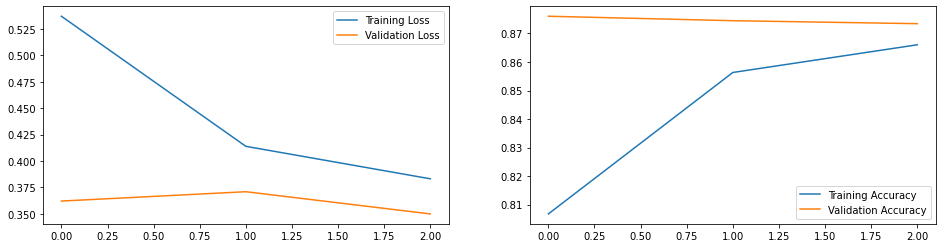

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,6.218009e-05,9.998808e-01,0.000195,0.027911,0.999871,0.001177,0.005432,0.076676,0.995194,0.004022,9.995345e-01,0.006721,0.007286,0.986370,9.994463e-01
Sports,9.999366e-01,8.895226e-07,0.000004,0.968563,0.000002,0.000091,0.994178,0.919902,0.000165,0.000021,4.983463e-07,0.041570,0.000131,0.000086,3.106517e-08
Business,2.506917e-07,1.037821e-04,0.065216,0.001365,0.000068,0.552267,0.000044,0.000325,0.001153,0.982875,4.506483e-04,0.023442,0.988206,0.010660,4.746910e-04
Sci/Tech,9.047520e-07,1.454490e-05,0.934585,0.002161,0.000059,0.446465,0.000345,0.003096,0.003489,0.013082,1.443337e-05,0.928267,0.004376,0.002885,7.895254e-05


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 256)         49408     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)               

In [42]:
cnn_model_4 = cnn4(encoder, num_classes=4)

In [44]:
# CNN Model, with 512 nodes

def cnn5(encoder, num_classes=4): 
    model2 = tf.keras.Sequential([encoder,
                                  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                                  tf.keras.layers.Conv1D(512, 3, activation='relu'),
                                  tf.keras.layers.GlobalMaxPooling1D(),
                                  tf.keras.layers.Dense(64, activation='relu'),
                                  tf.keras.layers.Dropout(0.75),
                                  # not binary since there are num_classes categories
                                  tf.keras.layers.Dense(num_classes, activation='softmax')
                                 ])

    model2.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   # if we set from_logits=True we do not have specify a softmax activation function in the last layer
                   metrics=['accuracy'])
    history2 = model2.fit(train_dataset,
                          epochs=20,
                          validation_data=validation_dataset,
                          validation_steps=30,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])
    
    test_loss, test_acc = model2.evaluate(test_dataset)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))
    history_dict2 = history2.history
    history_dict2.keys()
          
    history2_df=pd.DataFrame(history_dict2)
    history2_df.tail().round(3)

    losses = history2.history['loss']
    accs = history2.history['accuracy']
    val_losses = history2.history['val_loss']
    val_accs = history2.history['val_accuracy']
    epochs = len(losses)
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
          
    preds = model2.predict(test_dataset)
    preds.shape
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)  
    df = pd.DataFrame(preds[0:15], columns = ['World','Sports','Business','Sci/Tech']).T
    df.style.format("{:.2%}").background_gradient(cmap=cm)
    display(df)
    model2.summary()
    return model2

Epoch 1/20
1782/1782 [==============================] - 15s 8ms/step - loss: 0.6869 - accuracy: 0.7350 - val_loss: 0.4241 - val_accuracy: 0.8479
Epoch 2/20
1782/1782 [==============================] - 12s 7ms/step - loss: 0.5259 - accuracy: 0.8129 - val_loss: 0.4106 - val_accuracy: 0.8500
Epoch 3/20
1782/1782 [==============================] - 12s 7ms/step - loss: 0.4851 - accuracy: 0.8244 - val_loss: 0.3920 - val_accuracy: 0.8672
Epoch 4/20
1782/1782 [==============================] - 12s 7ms/step - loss: 0.4622 - accuracy: 0.8322 - val_loss: 0.3530 - val_accuracy: 0.8724
Epoch 5/20
1782/1782 [==============================] - 12s 7ms/step - loss: 0.4380 - accuracy: 0.8389 - val_loss: 0.3905 - val_accuracy: 0.8625
Epoch 6/20
119/119 [==============================] - 0s 4ms/step - loss: 0.4004 - accuracy: 0.8597
Test Loss: 0.400352418422699
Test Accuracy: 0.8597368597984314


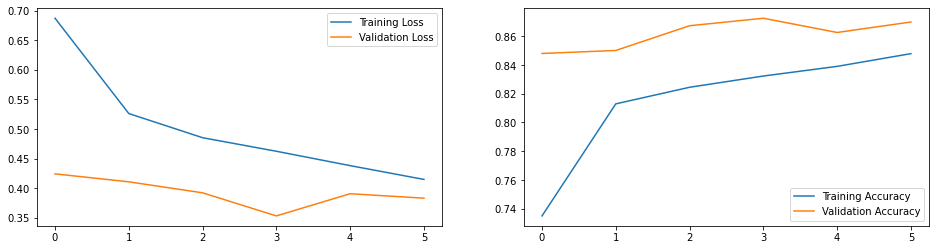

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,1.288958e-06,9.999928e-01,1.140548e-04,0.003730,9.998211e-01,0.001643,0.002037,0.092340,0.997297,1.279552e-03,9.999582e-01,0.003305,0.020640,0.963094,9.999933e-01
Sports,9.999987e-01,5.678209e-11,6.054047e-08,0.996255,2.913800e-08,0.000019,0.997925,0.891300,0.000002,5.448258e-08,8.484177e-11,0.000716,0.000037,0.000081,1.612427e-11
Business,9.352615e-14,4.658759e-06,1.232361e-01,0.000002,2.358589e-05,0.349096,0.000002,0.001571,0.000874,9.851905e-01,1.980231e-05,0.040111,0.866139,0.029814,2.925276e-06
Sci/Tech,1.393138e-11,2.526708e-06,8.766497e-01,0.000013,1.553485e-04,0.649242,0.000036,0.014790,0.001828,1.353000e-02,2.208394e-05,0.955867,0.113184,0.007011,3.760853e-06


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 512)         98816     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)               

In [45]:
cnn_model_5 = cnn5(encoder, num_classes=4)